<a href="https://colab.research.google.com/github/sovunia-hub/deep-learning/blob/main/MNIST_with_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets

#Предобработка

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

In [ ]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise()
])
data = datasets.MNIST('./', train=True, download=True, transform=transformer)
data_loader = DataLoader(data, batch_size=100, shuffle=True)

Данные с шумом мы используем для входа в сеть, а данные без шума - для оценки качества результата

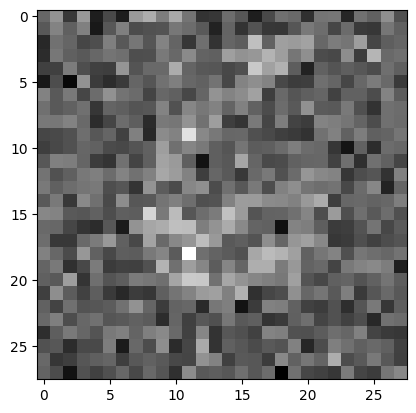

In [ ]:
plt.imshow(X_train_noise[90], cmap='gray')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#AE

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_fc1 = nn.Linear(784, 300)
        self.enc_fc2 = nn.Linear(300, 100)
        self.enc_fc3 = nn.Linear(100, 20)
        self.enc_fc4 = nn.Linear(20, 3)
        self.enc_relu = nn.ReLU()

        self.dec_fc1 = nn.Linear(3, 20)
        self.dec_fc2 = nn.Linear(20, 100)
        self.dec_fc3 = nn.Linear(100, 300)
        self.dec_fc4 = nn.Linear(300, 784)
        self.dec_relu = nn.ReLU()
        self.dec_sigmoid = nn.Sigmoid()

    def encode(self, x):
        x = self.enc_fc1(x)
        x = self.enc_relu(x)
        x = self.enc_fc2(x)
        x = self.enc_relu(x)
        x = self.enc_fc3(x)
        x = self.enc_relu(x)
        x = self.enc_fc4(x)
        return x

    def decode(self, z):
        x = self.dec_fc1(z)
        x = self.dec_relu(x)
        x = self.dec_fc2(x)
        x = self.dec_relu(x)
        x = self.dec_fc3(x)
        x = self.dec_relu(x)
        x = self.dec_fc4(x)
        x = self.dec_sigmoid(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon
Enc = Autoencoder()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Enc.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(Enc.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):
    total_loss = 0.0
    for data in data_loader:
        optimizer.zero_grad()
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        output = Enc(img)
        loss = criterion(output, img)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Эпоха: {epoch+1}, Ошибка: {total_loss/len(data_loader)}')

Эпоха: 1, Ошибка: 1.0609443632761637
Эпоха: 2, Ошибка: 1.0449173370997111
Эпоха: 3, Ошибка: 1.040788158774376
Эпоха: 4, Ошибка: 1.0386154518524806
Эпоха: 5, Ошибка: 1.0367953330278397
Эпоха: 6, Ошибка: 1.0361215688784917
Эпоха: 7, Ошибка: 1.0352245569229126
Эпоха: 8, Ошибка: 1.034437592625618
Эпоха: 9, Ошибка: 1.0341220595439276
Эпоха: 10, Ошибка: 1.0335045303901036


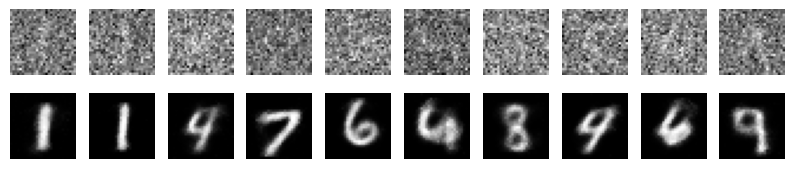

In [ ]:
with torch.no_grad():
    dataiter = iter(data_loader)
    img, _ = next(dataiter)
    img = img.view(img.size(0), -1).to(device)
    output = Enc(img)
    img = img.view(img.size(0), 1, 28, 28)
    output = output.view(output.size(0), 1, 28, 28)
    fig, ax = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        ax[0, i].imshow(img[i].cpu().numpy().squeeze(), cmap='gray')
        ax[1, i].imshow(output[i].cpu().numpy().squeeze(), cmap='gray')
        ax[0, i].axis('off')
        ax[1, i].axis('off')
    plt.show()

#Предобработка

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
transformer = transforms.Compose([
    transforms.ToTensor(),
])
data = datasets.MNIST('./', train=True, download=True, transform=transformer)
data_loader = DataLoader(data, batch_size=100, shuffle=True)

#VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, nc=1, ndf=64, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(ndf * 2 * 7 * 7, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, ndf * 2 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (ndf * 2, 7, 7)),
            nn.ConvTranspose2d(ndf * 2, ndf, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(ndf, nc, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    def encode(self, x):
        out = self.encoder(x)
        mu = out[:, :self.latent_dim]
        logvar = out[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
def loss_function(recon_x, x, mu, logvar, alpha=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return alpha * BCE + KLD

In [ ]:
vae = VAE()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
vae.train()
for epoch in range(10):
    total_loss = 0.0
    for data in data_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        reconstructed_img, mu, logvar = vae(img)
        loss = loss_function(reconstructed_img, img, mu, logvar)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Эпоха: {epoch+1}, Средняя ошибка: {total_loss / len(data_loader)}')

Эпоха: 1, Средняя ошибка: 16572.82370279948
Эпоха: 2, Средняя ошибка: 11942.822281901043
Эпоха: 3, Средняя ошибка: 11110.518442382812
Эпоха: 4, Средняя ошибка: 10817.841388346355
Эпоха: 5, Средняя ошибка: 10667.971404622396
Эпоха: 6, Средняя ошибка: 10565.384562174479
Эпоха: 7, Средняя ошибка: 10481.775994466147
Эпоха: 8, Средняя ошибка: 10424.614671223959
Эпоха: 9, Средняя ошибка: 10376.830319010416
Эпоха: 10, Средняя ошибка: 10332.283557942708


In [ ]:
def generate_sample(vae, latent_dim, num_samples, device):
    vae.eval()
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_data = vae.decode(z)
    return generated_data

generated_images = generate_sample(vae, 128, 25, device)

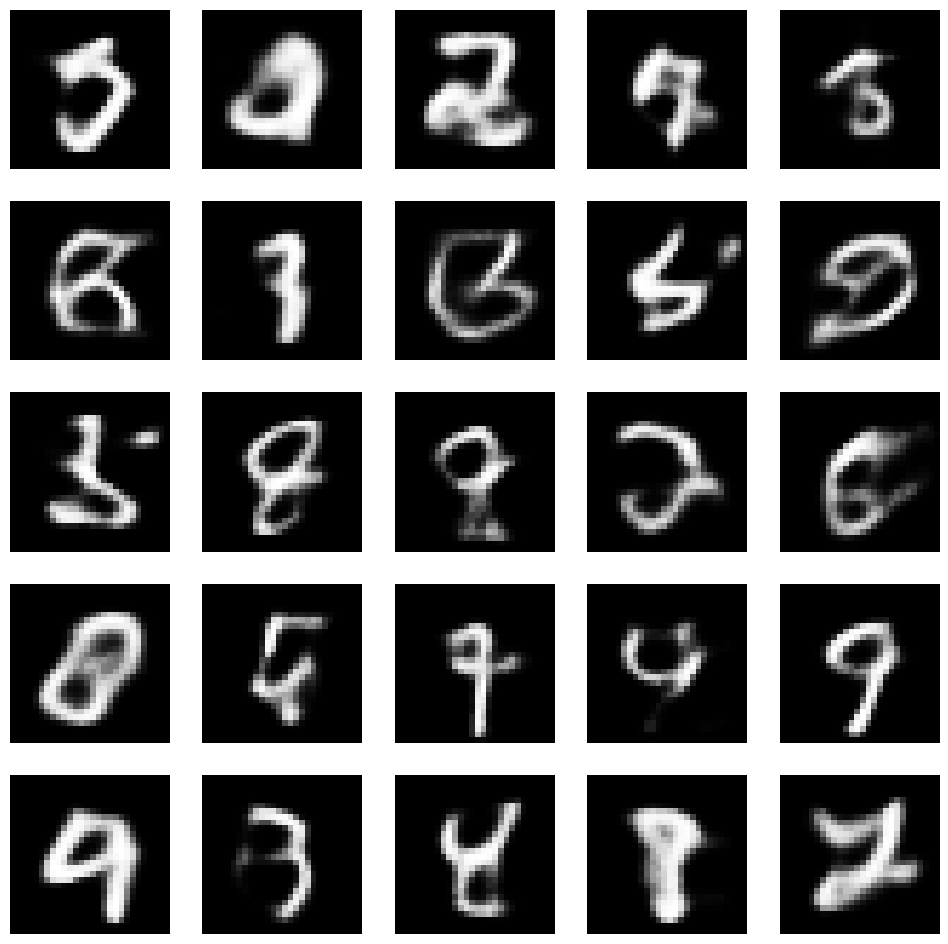

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()
for i, img in enumerate(generated_images):
    axs[i].imshow(img.squeeze().cpu(), cmap='gray')
    axs[i].axis('off')
plt.show()